In [1]:
import sys
sys.path.append("..")
from argparse import Namespace
from data import BavarianCrops, BreizhCrops, SustainbenchCrops, ModisCDL
from torch.utils.data import DataLoader

/home/marc/anaconda3/envs/elects/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
args = Namespace(
    sequencelength=70,
    dataroot = "/data/sustainbench",
    device="cuda",
    dataset = "southsudan"
)

dataroot = args.dataroot

from earlyrnn import EarlyRNN
nclasses = 4
input_dim = 19
model = EarlyRNN(nclasses=nclasses, input_dim=input_dim).to(args.device)
import torch
model.load_state_dict(torch.load("../snapshots/sustainbench/southsudan.pth"))
model.eval()

EarlyRNN(
  (intransforms): Sequential(
    (0): LayerNorm((19,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=19, out_features=64, bias=True)
  )
  (backbone): LSTM(64, 64, num_layers=2, bias=False, batch_first=True, dropout=0.2)
  (classification_head): ClassificationHead(
    (projection): Sequential(
      (0): Linear(in_features=64, out_features=4, bias=True)
      (1): LogSoftmax(dim=2)
    )
  )
  (stopping_decision_head): DecisionHead(
    (projection): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
)

In [4]:
use_s2_only = False
dataroot = args.dataroot
nclasses = 4
args.sequencelength = 365
input_dim = 12 if use_s2_only else 19 # 12 sentinel 2 + 3 x sentinel 1 + 4 * planet

#train_ds = SustainbenchCrops(root=dataroot,partition="train", sequencelength=args.sequencelength, country=args.dataset)

test_ds = SustainbenchCrops(root=dataroot,partition="test", 
                            sequencelength=args.sequencelength, 
                            country="southsudan", use_s2_only=use_s2_only)

caching to /data/sustainbench/npy/fullmax_pixNone


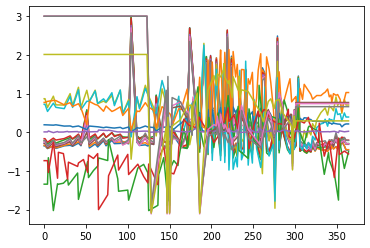

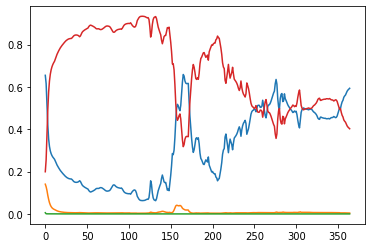

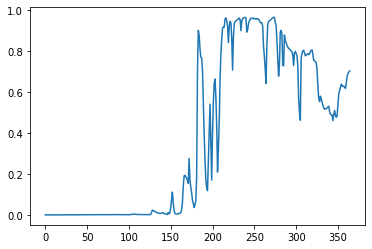

In [5]:
X,y = test_ds[9]
X = X.unsqueeze(0).to(args.device)
log_class_probabilities, probability_stopping = model(X)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(X[0].cpu().detach())
plt.figure()
plt.plot(log_class_probabilities[0].cpu().detach().exp())
plt.figure()
plt.plot(probability_stopping[0].cpu().detach())

In [6]:
import numpy as np
from tqdm.notebook import tqdm
dataloader = DataLoader(test_ds, batch_size=16)
device = args.device
model.eval()

stats = []
losses = []
for batch in tqdm(dataloader):
    X, y_true = batch
    X, y_true = X.to(device), y_true.to(device)

    log_class_probabilities, probability_stopping, predictions_at_t_stop, t_stop = model.predict(X)
    stat = {}
    stat["probability_stopping"] = probability_stopping.cpu().detach().numpy()
    stat["class_probabilities"] = log_class_probabilities.exp().cpu().detach().numpy()
    stat["predictions_at_t_stop"] = predictions_at_t_stop.unsqueeze(-1).cpu().detach().numpy()
    stat["t_stop"] = t_stop.unsqueeze(-1).cpu().detach().numpy()
    stat["targets"] = y_true.cpu().detach().numpy()

    stats.append(stat)


# list of dicts to dict of lists
stats = {k: np.vstack([dic[k] for dic in stats]) for k in stats[0]}

  0%|          | 0/440 [00:00<?, ?it/s]

In [6]:
y_pred = stats["predictions_at_t_stop"][:,0]
y_true = stats["targets"][:,0]

In [7]:
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, f1_score

print(classification_report(y_true, y_pred))

print(f1_score(y_true, y_pred,average="macro"))
print(accuracy_score(y_true, y_pred))
print(cohen_kappa_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      5675
           1       0.55      0.43      0.49       702
           2       1.00      1.00      1.00       196
           3       0.21      0.15      0.17       461

    accuracy                           0.82      7034
   macro avg       0.66      0.62      0.64      7034
weighted avg       0.80      0.82      0.81      7034

0.6367480416562589
0.8176002274665909
0.40164712064844155


In [14]:
t_stop = stats["t_stop"]
t_stop_mean = (t_stop / args.sequencelength).mean()
t_stop_std = (t_stop / args.sequencelength).std()

print(f"average stopping time {t_stop_mean*100:.2f}% +- {t_stop_std*100:.2f}%")

average stopping time 17.65% +- 19.65%


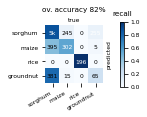

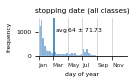

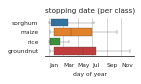

In [16]:

from sklearn.metrics import confusion_matrix, accuracy_score
import datetime

doy_stop = t_stop[:,0]


pt2inch = 0.0138888889
textsize = 345 # pt
textsize_inch = textsize*pt2inch

plt.rc('font', size=6) 
plt.rc("axes.spines", top=False, right=False, bottom=False, left=False)


acier = "#4F8FCC"
y_pred = stats["predictions_at_t_stop"][:,0]
y_true = stats["targets"][:,0]


cm_norm = confusion_matrix(y_pred, y_true, normalize="true")
cm = confusion_matrix(y_pred, y_true)

fig, ax = plt.subplots(1,1, figsize=(textsize_inch*0.33,4))


labels_names = ['sorghum', 'maize', 'rice', 'groundnut']

ax.set_xticks(range(len(labels_names)))
ax.set_xticklabels(labels_names, rotation=30, ha="right")

ax.set_yticks(range(len(labels_names)))
ax.set_yticklabels(labels_names, rotation=0, ha="right")

im = ax.imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "white" if cm_norm[i,j] > 0.5 else "black"
        txt = str(cm[i,j])
        txt = txt[:-3] + "k" if len(txt) > 3 else txt
        ax.text(i,j, txt, ha="center", va="center", color=color)
        
cbar = fig.colorbar(im, ax=ax, location='right', shrink=0.3, pad = 0.2)
cbar.ax.set_title('recall')

ax.yaxis.set_label_position("right")
ax.set_ylabel("predicted")
ax.xaxis.set_label_position("top")
ax.set_xlabel("true")

ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,  
    left=True,# ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off


accuracy = accuracy_score(y_pred, y_true)
ax.set_title(f"ov. accuracy {accuracy*100:.0f}%")      
fig.savefig("/home/marc/Desktop/elects/southsudan_confmat.pdf",dpi=300,bbox_inches='tight')

fig, ax = plt.subplots(1,1, figsize=(textsize_inch*0.33,0.7))
        
import seaborn
seaborn.set_style("white")

seaborn.histplot(x=doy_stop,ax=ax, color=acier, binwidth=7)
seaborn.despine(offset=0, left=True)
ax.set_xlabel("day of year")
ax.set_ylabel("frequency")
ax.set_xlim(0,365)
t = np.linspace(0,360,4)
#ax.set_ylim(-.5,1)
ys = [0.55,0.75,0.55,0.75]
#ax.set_xticks(doys)
ax.set_title(f"stopping date (all classes)")
ax.axvline(doy_stop.mean())
ax.text(doy_stop.mean()+5,1000, f"avg {doy_stop.mean():.0f} $\pm$ {doy_stop.std():.2f}", color="black")
#ax.set_xticklabels(dates, rotation=20, ha='right')

doys_months = [datetime.datetime(2017,m,1).timetuple().tm_yday for m in range(1,13,2)]
months = ["Jan", "Mar", "May","Jul", "Sep", "Nov"]

ax.xaxis.grid(True)
ax.set_xticks(doys_months)
ax.set_xticklabels(months, ha="left")

fig.savefig("/home/marc/Desktop/elects/southsudan_violin.pdf",dpi=300,bbox_inches='tight')

import seaborn
import matplotlib.pyplot as plt

import datetime



fig, ax = plt.subplots(figsize=(textsize_inch*0.33,0.7))
seaborn.boxplot(x=doy_stop,y=stats["targets"][:,0],orient="h",ax=ax,showfliers = False,linewidth=0.3)
ax.set_yticklabels(labels_names)
ax.set_xlabel("day of year")

doys_months = [datetime.datetime(2017,m,1).timetuple().tm_yday for m in range(1,13,2)]
months = ["Jan", "Mar", "May","Jul", "Sep", "Nov"]

ax.set_title(f"stopping date (per class)")
ax.xaxis.grid(True)
ax.set_xticks(doys_months)
ax.set_xticklabels(months, ha="left")


seaborn.despine(left=True)
fig.savefig("/home/marc/Desktop/elects/southsudan_classearliness.pdf", transparent=True, bbox_inches="tight")

UsageError: Line magic function `%ax.set_yticklabels(labels_names,` not found.


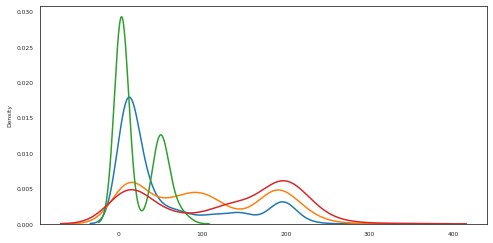

In [18]:
import seaborn
import matplotlib.pyplot as plt

import datetime

doys_months = [datetime.datetime(2017,m,1).timetuple().tm_yday for m in range(1,13)]
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

fig, ax = plt.subplots(figsize=(8,4))

for cl, name in zip(np.unique(stats["targets"][:,0]), labels_names):
    msk = stats["targets"][:,0] == cl
    seaborn.kdeplot(x=doy_stop[msk],ax=ax)

    
%ax.set_yticklabels(labels_names, fontsize=16)
ax.set_xlabel("day of year", fontsize=16)

ax.xaxis.grid(True)
ax.set_xticks(doys_months)
ax.set_xticklabels(months, ha="left")

seaborn.despine(left=True)
fig.savefig("/home/marc/projects/re-elects/images/phenology/ghana.pdf", transparent=True, bbox_inches="tight")